In [ ]:
from google.colab import files
files.upload()

Saving rice-production.csv to rice-production.csv


{'rice-production.csv': b'Entity,Code,Year,"Crops - Rice, paddy - 27 - Production - 5510 - tonnes"\nAfghanistan,AFG,1961,319000\nAfghanistan,AFG,1962,319000\nAfghanistan,AFG,1963,319000\nAfghanistan,AFG,1964,380000\nAfghanistan,AFG,1965,380000\nAfghanistan,AFG,1966,337000\nAfghanistan,AFG,1967,396000\nAfghanistan,AFG,1968,402000\nAfghanistan,AFG,1969,407000\nAfghanistan,AFG,1970,366000\nAfghanistan,AFG,1971,350000\nAfghanistan,AFG,1972,400000\nAfghanistan,AFG,1973,420000\nAfghanistan,AFG,1974,420000\nAfghanistan,AFG,1975,435000\nAfghanistan,AFG,1976,448000\nAfghanistan,AFG,1977,400000\nAfghanistan,AFG,1978,428000\nAfghanistan,AFG,1979,439000\nAfghanistan,AFG,1980,415000\nAfghanistan,AFG,1981,390000\nAfghanistan,AFG,1982,364000\nAfghanistan,AFG,1983,350000\nAfghanistan,AFG,1984,334000\nAfghanistan,AFG,1985,317000\nAfghanistan,AFG,1986,336000\nAfghanistan,AFG,1987,324000\nAfghanistan,AFG,1988,343000\nAfghanistan,AFG,1989,320000\nAfghanistan,AFG,1990,333000\nAfghanistan,AFG,1991,335000\nA

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
from sklearn.metrics import r2_score
from keras.models import load_model
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [ ]:
#importing data
path='rice-production.csv'
df = read_csv(path)
df.columns = ['Region', 'Code','Year','Production']
#df.head()
country=df[df['Code']=='LKA'].copy()
country['MA']=country['Production'].rolling(window=3).mean()
country.iat[0,-1]=country.iloc[0,-2]
country.iat[1,-1]=country.iloc[1,-2]
country.iat[2,-1]=country.iloc[2,-2]
series=DataFrame()
series['Year']=country['Year'].values
series['Production']=country['Production'].values
#series['Production']=country['MA'].values
series=series.set_index('Year')
print(series.head())
#series.to_csv('shampoo.csv')

      Production
Year            
1961      923024
1962     1029194
1963     1045908
1964     1074049
1965      764158


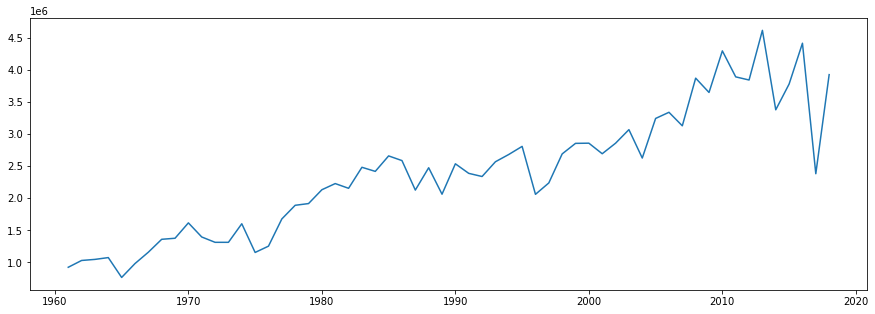

In [ ]:
#plotting the points in the datarame
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=[15,5])
#ax.plot(country['Year'],country['MA'])
ax.plot(country['Year'],country['Production'])

In [ ]:
# load dataset
#series = read_csv('shampoo.csv', header=0, index_col=0, squeeze=True,)
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-9], supervised_values[-10:]
print(len(train),len(test))
# transform the scale of the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)
train_scaled, test_scaled = scale(train, test)


48 10


In [ ]:
repeats = 30
error_scores = list()
min_rmse=1000000000
epocs=150
neuron=5
for r in range(repeats):
# fit the model
    lstm_model = fit_lstm(train_scaled, 1,epocs,neuron)
# forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
# walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
# make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
# invert scaling
        yhat = invert_scale(scaler, X, yhat)
# invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
# store forecast
        predictions.append(yhat)
# report performance
    r2 = r2_score(raw_values[-10:], predictions)
    rmse = sqrt(mean_squared_error(raw_values[-10:], predictions))
    print('%d) Test RMSE: %.3f,R2:%.5f' % (r+1, rmse,r2))
    error_scores.append(rmse)
    if(rmse<min_rmse):
      min_rmse=rmse
      lstm_model.save('BTN_'+str((r+1))+'_'+str((epocs))+str(neuron)+'.h5')  # creates a HDF5 file 'my_model.h5'
      Predictions=DataFrame(data=predictions)
      Predictions.to_csv('BTN_'+str((r+1))+'_'+str((epocs))+str(neuron)+'.csv')


1) Test RMSE: 171922.487,R2:0.26072
2) Test RMSE: 181371.861,R2:0.17722
3) Test RMSE: 179756.509,R2:0.19181
4) Test RMSE: 189908.577,R2:0.09794
5) Test RMSE: 169054.107,R2:0.28518
6) Test RMSE: 179887.015,R2:0.19063
7) Test RMSE: 186066.625,R2:0.13407
8) Test RMSE: 169237.311,R2:0.28363
9) Test RMSE: 157026.079,R2:0.38328
10) Test RMSE: 183641.069,R2:0.15650
11) Test RMSE: 175100.570,R2:0.23313
12) Test RMSE: 178551.379,R2:0.20261
13) Test RMSE: 177097.382,R2:0.21554
14) Test RMSE: 173749.724,R2:0.24492
15) Test RMSE: 189303.907,R2:0.10368
16) Test RMSE: 168369.895,R2:0.29095
17) Test RMSE: 192113.257,R2:0.07688
18) Test RMSE: 174441.405,R2:0.23889
19) Test RMSE: 181283.434,R2:0.17802
20) Test RMSE: 176714.116,R2:0.21893
21) Test RMSE: 175104.295,R2:0.23310
22) Test RMSE: 176250.794,R2:0.22302
23) Test RMSE: 173953.635,R2:0.24314
24) Test RMSE: 175975.849,R2:0.22545
25) Test RMSE: 171650.146,R2:0.26306
26) Test RMSE: 174962.273,R2:0.23434
27) Test RMSE: 178105.771,R2:0.20658
28) Test R

In [ ]:
from keras.models import load_model
#lstm_model.save('my_model_PAK10.h5')  # creates a HDF5 file 'my_model.h5'
#del lstm_model  # deletes the existing model
# returns a compiled model
# identical to the previous one
lstm_model = load_model('BTN_9_1505.h5')

In [ ]:
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
test_predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	test_predictions.append(yhat)
test_pred_data=numpy.array(test_predictions).reshape(1,-1)[0]

Test RMSE: 1145926.577
-2.7115645716555083


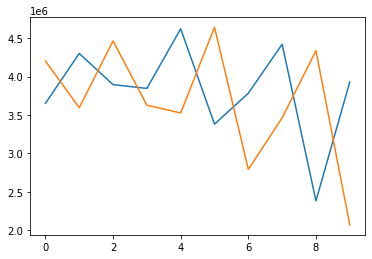

In [ ]:
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-10:], test_predictions))
print('Test RMSE: %.3f' % rmse)
from sklearn.metrics import r2_score
r2 = r2_score(raw_values[-10:], test_predictions)
print(r2)
#from sklearn.metrics import accuracy_score
#acc=accuracy_score(raw_values[-10:], predictions)
#print(acc)
# line plot of observed vs predicted
pyplot.plot(raw_values[-10:])
#pyplot.plot(country['Production'][-10:])
pyplot.plot(test_predictions)
pyplot.show()

In [ ]:
lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (1, 3)                    60        
_________________________________________________________________
dense_9 (Dense)              (1, 1)                    4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
#lstm_model.predict(train_reshaped, batch_size=1)
predictions = list()
for i in range(len(train_scaled)):
	# make one-step forecast
	X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
	#print(X)
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
train_pred=numpy.array(predictions).reshape(1,-1)[0]


Test RMSE: 20572.091
-3.116172598508628


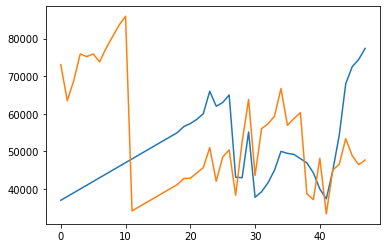

In [ ]:
rmse = sqrt(mean_squared_error(raw_values[:-10], predictions))
print('Test RMSE: %.3f' % rmse)
from sklearn.metrics import r2_score
r2 = r2_score(raw_values[:-10], predictions)
print(r2)
# line plot of observed vs predicted
pyplot.plot(raw_values[:-10])
pyplot.plot(predictions)
pyplot.show()

In [ ]:
test_pred_data=DataFrame(data=test_pred_data)
test_pred_data.to_csv('Test_BTN.csv')
train_pred=DataFrame(data=train_pred)
train_pred.to_csv('Train_BTN.csv')